In [89]:
import numpy as np
import pandas as pd

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    RocCurveDisplay,
    roc_curve,
    classification_report,
    auc,
)

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Load model and data

In [90]:
# path to store trained model
model_path = "01_dane/04_models"

# path to input dataset
data_path = "01_dane/03_modeling_data"

In [91]:
# load data new
df_new = pd.read_csv(f"{data_path}/base_new.csv")
# use modified status column
df_new["STATUS"] = df_new["NEW_STATUS"]
df_new = df_new.drop(columns=["NEW_STATUS"])

# load data old
df_old = pd.read_csv(f"{data_path}/base_old.csv")

# merge them
df = pd.concat([df_old, df_new])

# prepare df with only model features
y_col = "STATUS"
X = df.drop(columns=[y_col, "dataset"])


In [92]:
# Load models
with open(f"{model_path}/lgb_old.pkl", "rb") as fin:
    model_old = pickle.load(fin)

with open(f"{model_path}/lgb_new.pkl", "rb") as fin:
    model_new = pickle.load(fin)

# SHAP

In [93]:
# Shap on new model
explainer_new = shap.TreeExplainer(model_new)
shap_values_new = explainer_new.shap_values(X)

# Shap on old model
explainer_old = shap.TreeExplainer(model_old)
shap_values_old = explainer_old.shap_values(X)

/home/julian/.venvs/std_env/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/julian/.venvs/std_env/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


## Explain on observation level

Shap values are estimated on variable | observation level.  
They estimate the efect of variable=x on final predition  
In this way they decompose the predition to specific features

In [94]:
# new model

shap.initjs()
# id of observation to 'explain'
obs_id = 1
shap.force_plot(
    explainer_new.expected_value, shap_values_new[obs_id, :], X.iloc[obs_id, :]
)


In [95]:
# old model (for the same observation)
shap.force_plot(
    explainer_old.expected_value, shap_values_old[obs_id, :], X.iloc[obs_id, :]
)


Shap values are expressed in raw prediton values -> log-odds in most cases,

In [96]:
log_odds = -2.05
odds = np.exp(log_odds)
prob = (odds) / (1 + odds)

print(f"Log-odds = {log_odds}")
print(f"Odds = {round(odds, 4)}")
print(f"Probability = {round(prob, 4)}")

Log-odds = -2.05
Odds = 0.1287
Probability = 0.1141


## Feature importance

If each shap value for each observation and variable explain how it influenced the final prediton  
We can aggregate them to variable level to get averege efect of each variable  
* As the effect can be both positive and negative we take te aboslute value
* Feature importance as mean(abs(shap))

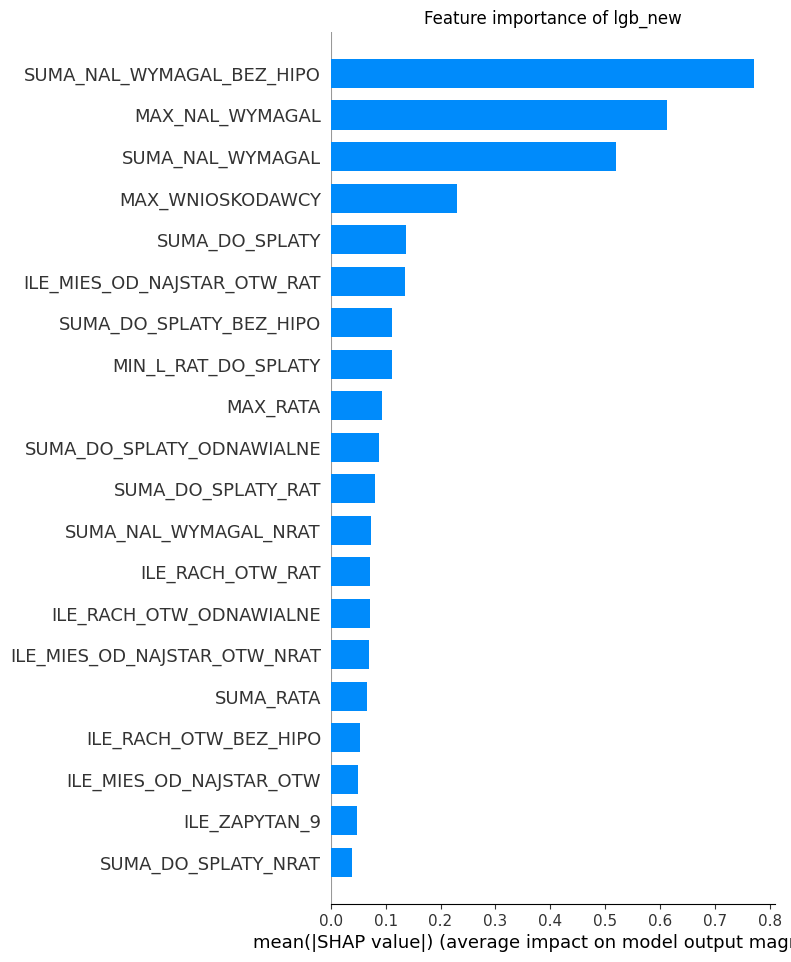

In [97]:
model_name = "lgb_new"
plot_save_path = f"03_results/{model_name}"
shap.summary_plot(shap_values_new, X, plot_type="bar", show=False)
plt.title(f"Feature importance of {model_name}")
plt.savefig(f"{plot_save_path}/feature_importance.png")

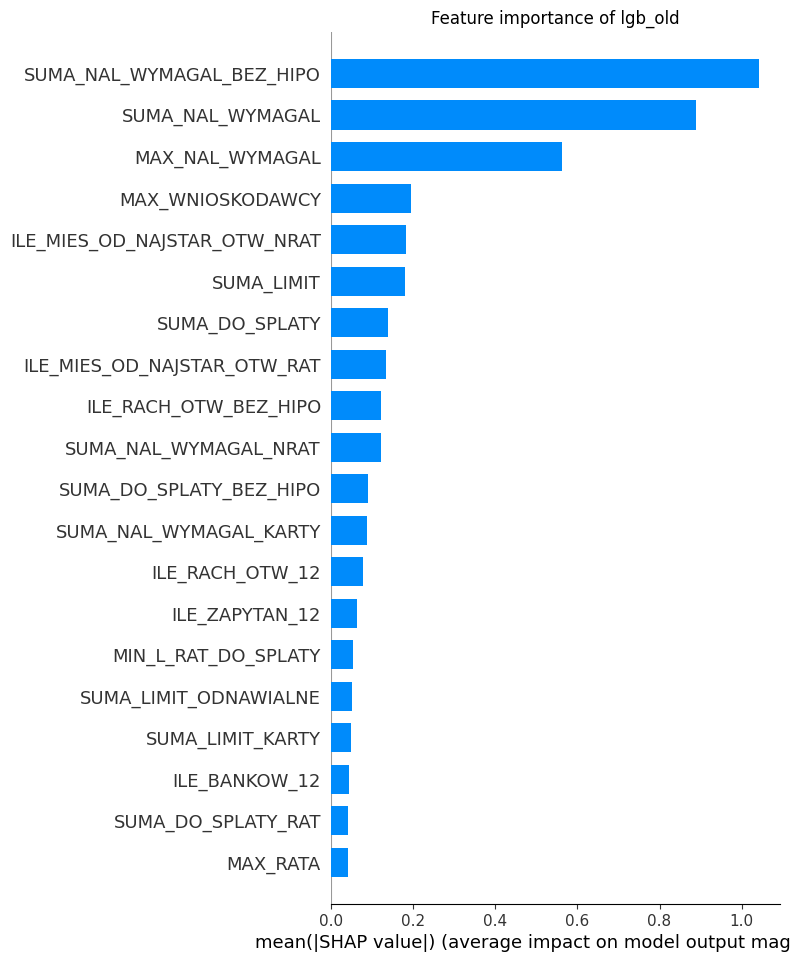

In [98]:
model_name = "lgb_old"
plot_save_path = f"03_results/{model_name}"
shap.summary_plot(shap_values_old, X, plot_type="bar", show=False)
plt.title(f"Feature importance of {model_name}")
plt.savefig(f"{plot_save_path}/feature_importance.png")


Here is more general plot which shows the overall effect for each variable  
Each dot is one observation, and corresponding shap value

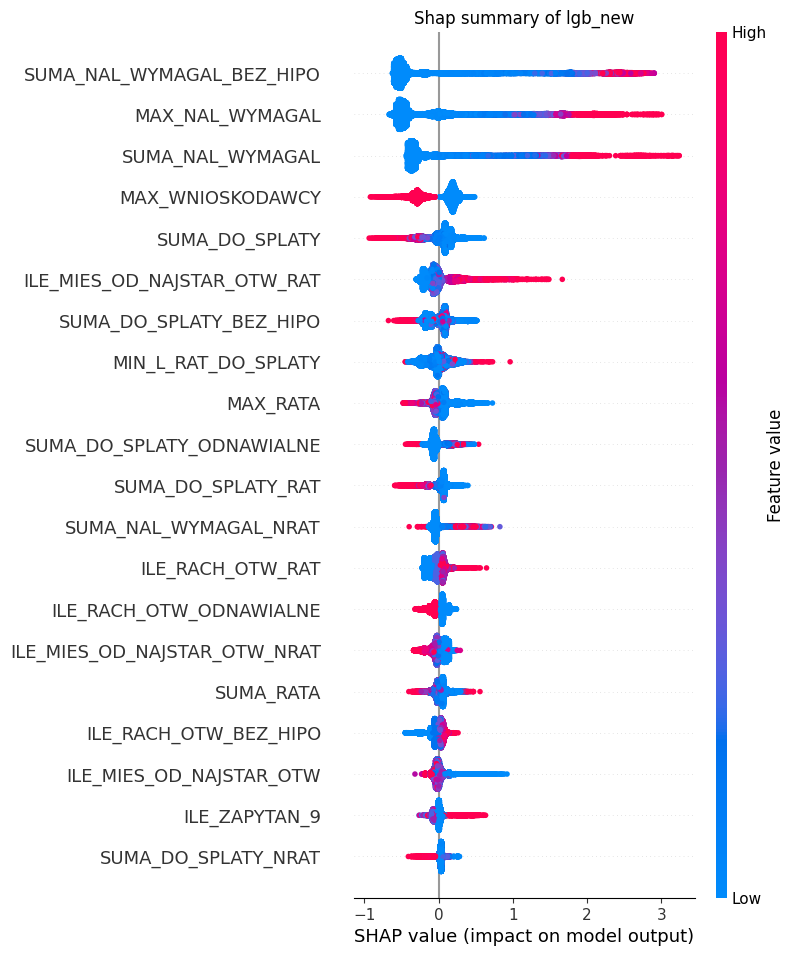

In [99]:
model_name = "lgb_new"
plot_save_path = f"03_results/{model_name}"
shap.summary_plot(shap_values_new, X, show=False)
plt.title(f"Shap summary of {model_name}")
plt.savefig(f"{plot_save_path}/shap_summary.png")


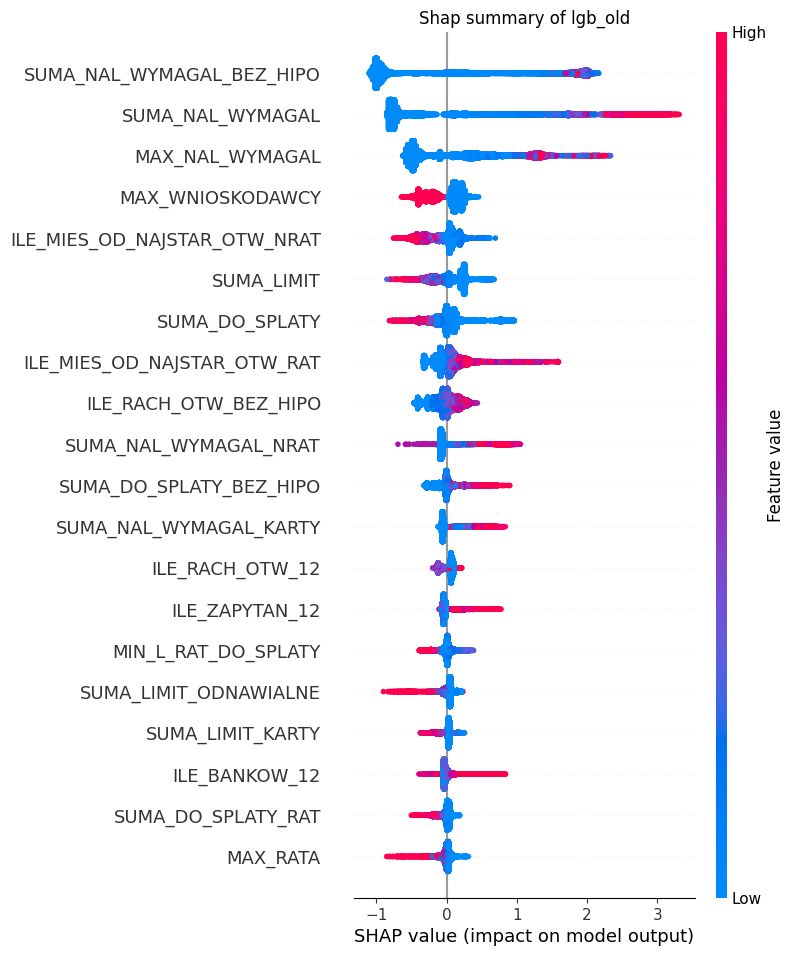

In [100]:
model_name = "lgb_old"
plot_save_path = f"03_results/{model_name}"
shap.summary_plot(shap_values_old, X, show=False)
plt.title(f"Shap summary of {model_name}")
plt.savefig(f"{plot_save_path}/shap_summary.png")


In [101]:
# Here are more detail plots, for each variable and thier levels
# As we can see we have interations in our model
# The impact of variable is different for the same value
# ILE bankow=1 can have both positive and negative effect on our preditions
# If ILE_BANKOW=1 and SUMA_RATA is below 1500 then it has positive effect (risk is higher)
# If ILE_BANKOW=1 and SUMA_RATA is above 1500 then it has negative effect (risk is lower) -> probably it is one big loan, like morgage so it do not have that negative effect

model_name = "lgb_new"
plot_save_path = f"03_results/{model_name}/variables"

for name in X.columns:
    shap.dependence_plot(name, shap_values_new, X, display_features=X, show=False)
    plt.title(f"Shap values of model {model_name} for {name}")
    plt.savefig(f"{plot_save_path}/{name}.png")
    plt.close()

In [102]:
model_name = "lgb_old"
plot_save_path = f"03_results/{model_name}/variables"

for name in X.columns:
    shap.dependence_plot(name, shap_values_old, X, display_features=X, show=False)
    plt.title(f"Shap values of model {model_name} for {name}")
    plt.savefig(f"{plot_save_path}/{name}.png")
    plt.close()

# Compare predicted values

The comparisons focus on predicted values between models.  
In case that models would be simmilar then all observations would lie on diagonal as new_pred = old_pred.  

Based on this we can examine how much different model preditions are.  
If we assume that models are able to correctly fit to the underlying samples, then devations from diagonal line show how much underlying samples differ.  

**As samples are not balanced in terms of % of defaulted customers, it is expected that model traind on larger number of defaults will predict higher probability.**

**For this reason changes in discriminatory power of specific variables, should be more representative.**

In [103]:
df_plot = df[["STATUS", "dataset"]].copy()

df_plot["pred_old"] = model_old.predict_proba(X)[:, 1]
df_plot["pred_new"] = model_new.predict_proba(X)[:, 1]

<Axes: xlabel='pred_old', ylabel='pred_new'>

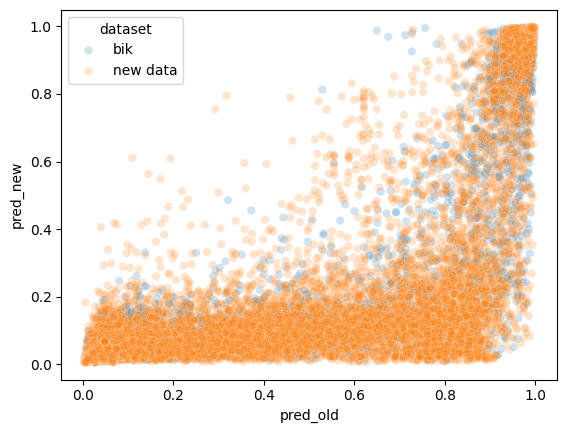

In [104]:
sns.scatterplot(
    df_plot,
    x="pred_old",
    y="pred_new",
    hue="dataset",
    alpha=0.2,
)

<Axes: xlabel='pred_old', ylabel='pred_new'>

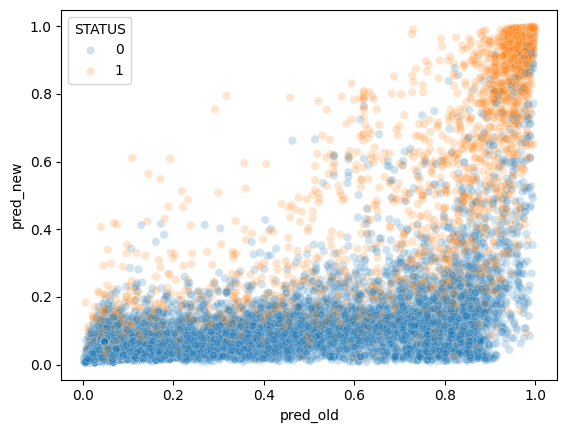

In [105]:
mask = df_plot["dataset"] == "new data"
sns.scatterplot(
    df_plot[mask],
    x="pred_old",
    y="pred_new",
    hue="STATUS",
    alpha=0.2,
)

<Axes: xlabel='pred_old', ylabel='pred_new'>

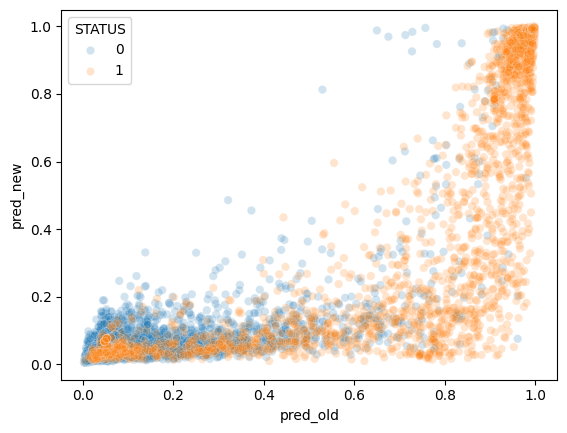

In [106]:
mask = df_plot["dataset"] == "bik"
sns.scatterplot(
    df_plot[mask],
    x="pred_old",
    y="pred_new",
    hue="STATUS",
    alpha=0.2,
)

## Compare predictive power

In [107]:
def model_summary(model, X: pd.DataFrame, y: pd.DataFrame):
    # predict on test set
    pred = model.predict(X)
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()

    # predict_proba returns probability for both 0 and 1,
    # for this reason we need to pick only one column with probs for STATUS=1
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    print(f"AUC = {round(roc_auc, 4)}")


In [108]:
# get two versions of datasets
X_new = df_new.drop(columns=[y_col, "dataset"])
y_new = df_new[y_col]

X_old = df_old.drop(columns=[y_col, "dataset"])
y_old = df_old[y_col]

### new model

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     19390
           1       0.95      0.75      0.84      5041

    accuracy                           0.94     24431
   macro avg       0.95      0.87      0.90     24431
weighted avg       0.94      0.94      0.94     24431

AUC = 0.9601


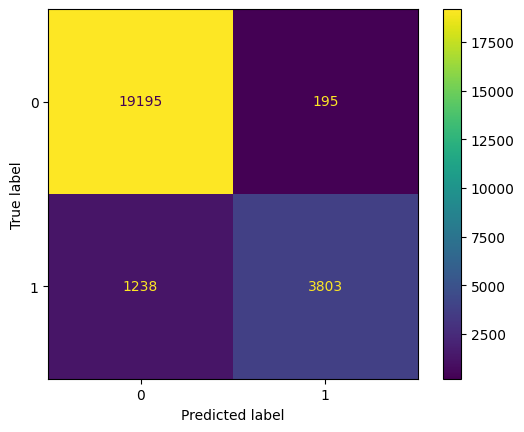

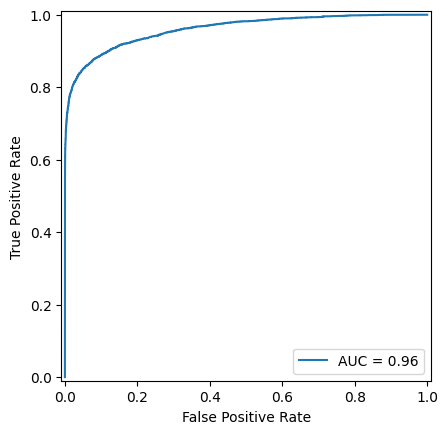

In [109]:
# summary of new model on new data
model_summary(model_new, X_new, df_new["STATUS"])

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      9929
           1       0.98      0.73      0.84      5027

    accuracy                           0.91     14956
   macro avg       0.93      0.86      0.89     14956
weighted avg       0.91      0.91      0.90     14956

AUC = 0.95


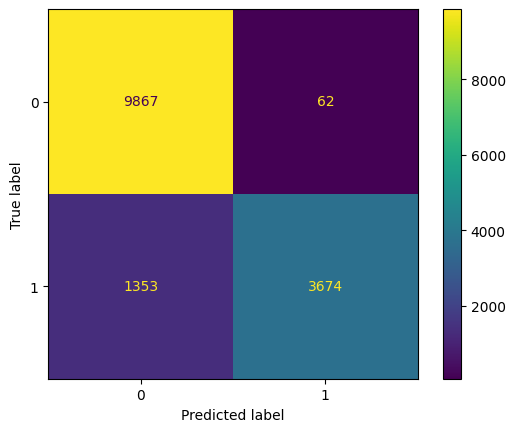

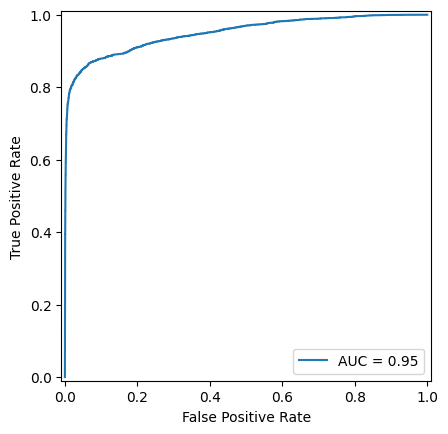

In [110]:
# summary of new model on old data
model_summary(model_new, X_old, df_old["STATUS"])

### Old model

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      9929
           1       0.95      0.88      0.91      5027

    accuracy                           0.94     14956
   macro avg       0.94      0.93      0.93     14956
weighted avg       0.94      0.94      0.94     14956

AUC = 0.9778


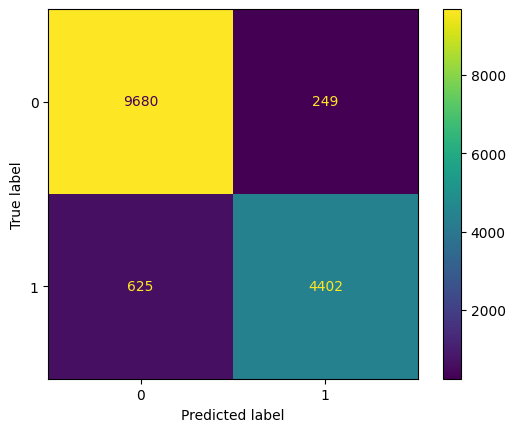

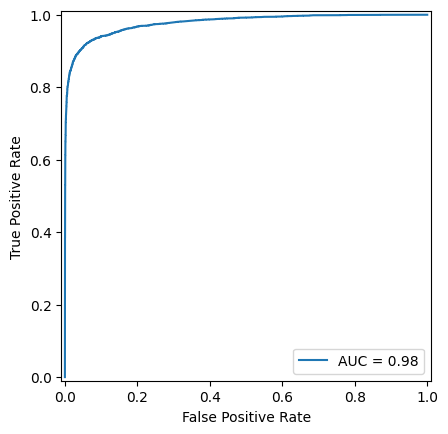

In [111]:
# summary of old model on old data
model_summary(model_old, X_old, df_old["STATUS"])

              precision    recall  f1-score   support

           0       0.96      0.82      0.88     19390
           1       0.55      0.86      0.67      5041

    accuracy                           0.82     24431
   macro avg       0.75      0.84      0.77     24431
weighted avg       0.87      0.82      0.84     24431

AUC = 0.923


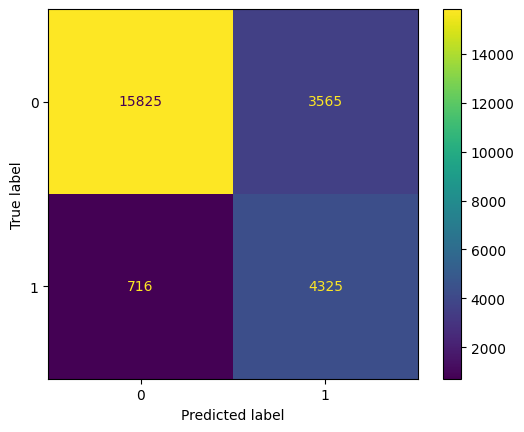

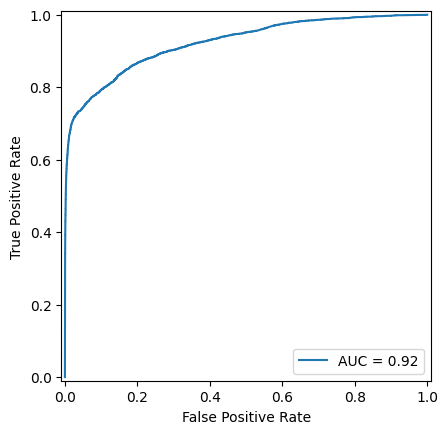

In [112]:
# summary of old model on new data
model_summary(model_old, X_new, df_new["STATUS"])